In [1]:
from ham import *
from matplotlib.animation import FuncAnimation 
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# ==== Model Parameters ====
batch_size = 1000
n_image = 28*28
n_classes = 10
n_hidden = 32**2
device = torch.device('cuda')
dtype = torch.float32

In [3]:
# ==== Create Model ====
neurons = {
    'image': SphericalNeuron(shape=(n_image,)),
    'label': SoftmaxNeuron(shape=(n_classes,), beta=0.005)
}

synapses = {
    's0': HopfieldSynapse(n_image, n_classes, n_hidden, beta=7.0, device=device, dtype=dtype)
}

connections = {
    's0': ['image', 'label']
}

model = HAM(neurons, synapses, connections)

In [4]:
# ==== Load Data ====
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0), (1.0))])
train_set = datasets.MNIST(os.path.expanduser('~/data'), train=True, download=True, transform=transform)
test_set = datasets.MNIST(os.path.expanduser('~/data'), train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [5]:
# ==== Optimization setup ====
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
n_epochs = 2
depth = 1
dt = 0.5

In [6]:
for e in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        
        # Init states
        states = model.init_states(batch_size=batch_size, device=device, dtype=dtype, requires_grad=True)
        states['image'] = torch.flatten(x, start_dim=1).to(device=device, dtype=dtype).requires_grad_(True)

        # Move labels to device
        y = y.to(device=device, dtype=torch.long)

        optim.zero_grad()

        for d in range(depth):
            activations = model.activations(states)
            updates = model.updates(states, activations)
            states = model.step(states, updates, dt, pin={'image'})
        
        logits = states['label']
        loss = F.cross_entropy(logits, y)
        print(f'epoch = {e+1:03d}/{n_epochs:03d}, batch = {i+1:05d}/{len(train_loader):05d}, loss = {loss.item():2.8f}', end='\r',  flush=True)
        loss.backward()
        optim.step()

Text(0.5, 1.0, '4')

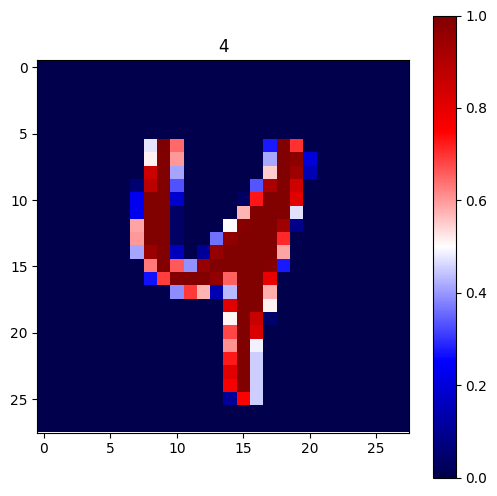

In [7]:
# Plot results
idx = 42
x, y = test_set[idx]
x = x.view(1, -1).to(device=device, dtype=dtype)
y = torch.tensor(y).view(1, -1).to(device=device, dtype=torch.long)

plt.figure(figsize=(6, 6))
plt.imshow(x.detach().cpu().squeeze().reshape(28, 28).numpy(), cmap='seismic')
plt.colorbar()
plt.title(f'{y.item()}')

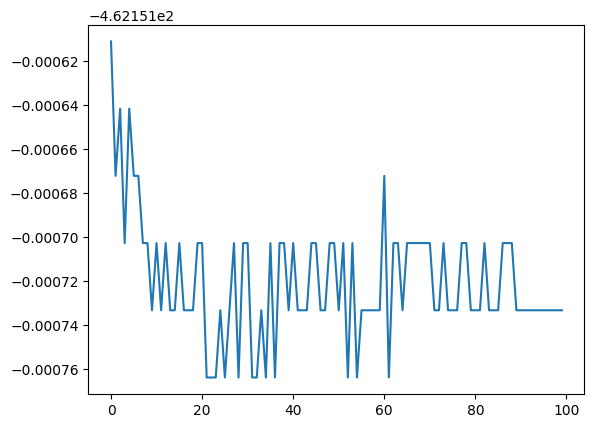

In [8]:
states = model.init_states(batch_size=1, device=device, dtype=dtype, requires_grad=True)
states['image'] = x.requires_grad_(True)

dt = 0.01
nt = 100
energies = []
for t in range(nt):
    activations = model.activations(states)
    updates = model.updates(states, activations)
    energies.append(model.energy(states, activations).item())
    states = model.step(states, updates, dt, pin={'image'})
    
plt.plot(energies)

In [9]:
activations = model.activations(states)
probs = activations['label']
y_pred = torch.argmax(probs.flatten())
print(f'y_true = {y.item()}, y_pred = {y_pred.item()}')

y_true = 4, y_pred = 4


<IPython.core.display.Javascript object>


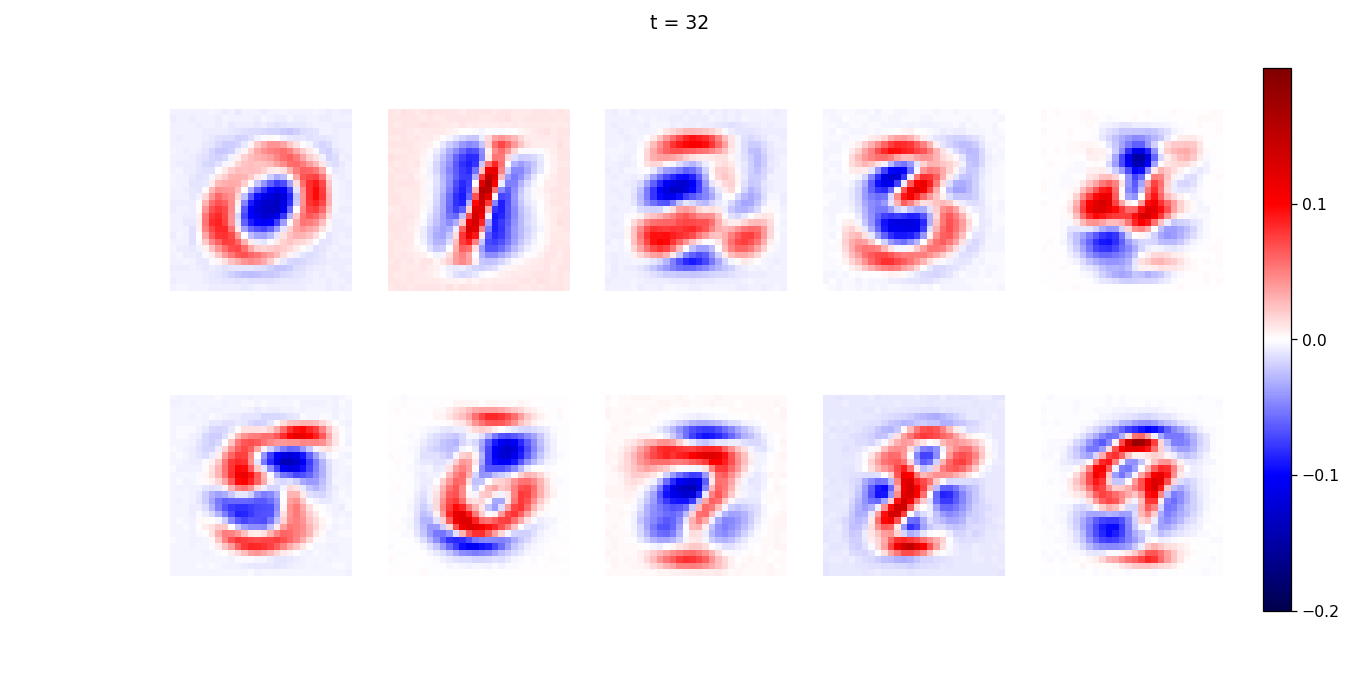

In [10]:
%matplotlib notebook

active = 1e3
inactive = 1
dt = 0.01
nt = 40

fig = plt.figure(figsize=(12, 6))
states = model.init_states(batch_size=1, device=device, dtype=dtype, requires_grad=True)
activations = model.activations(states)
ims = [None]*10
for i in range(10):
    
    ax = fig.add_subplot(2, 5, i+1)
    ims[i] = ax.imshow(activations['image'].detach().cpu().reshape(28, 28).numpy(), cmap='seismic', clim=(-0.2, 0.2))
    if i == 0:
        cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
        cbar = fig.colorbar(ims[i], cax=cb_ax)
        cbar.set_ticks(np.arange(-0.2, 0.2, 0.1))
    ax.axis('off')

def animate(j):
    for digit in range(10):
        states = model.init_states(batch_size=1, device=device, dtype=dtype, requires_grad=True)
        states['label'] = torch.full((1, 10), fill_value=inactive, device=device, dtype=dtype)
        states['label'][0,digit] = active
        states['label'].requires_grad = True

        for t in range(j):
            activations = model.activations(states)
            updates = model.updates(states, activations)
            states = model.step(states, updates, dt, pin={'label'})

        activations = model.activations(states)
        ims[digit].set_data(activations['image'].detach().cpu().reshape(28, 28).numpy())
        
    plt.suptitle(f't = {j:02d}')
    
    return ims

anim = FuncAnimation(fig, animate, frames = nt, interval = 50, blit = True)

In [11]:
anim.save('energy_descent.gif', writer='ffmpeg', fps=5)